# Amazon Reviews Sentiment Analysis

This notebook analyzes Amazon product reviews for sentiment analysis using the provided test.ft.txt and train.ft.txt files.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Set style for plots
plt.style.use('seaborn')
sns.set_palette("husl")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dines\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dines\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\dines\AppData\Local\Temp\ipykernel_20300\3387489221.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
# Function to read and preprocess the data
import re

def read_amazon_reviews(file_path):
    reviews = []
    labels = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            # Extract label using regex
            match = re.match(r'__label__(\d)\s+(.*)', line)
            if match:
                label = int(match.group(1))
                text = match.group(2).strip()
                reviews.append(text)
                labels.append(label)
            else:
                # Skip lines that do not match the expected format
                continue
    
    # Convert to DataFrame
    df = pd.DataFrame({
        'review': reviews,
        'sentiment': labels
    })
    
    # Convert sentiment from 1,2 to 0,1 for negative/positive
    df['sentiment'] = df['sentiment'].map({1: 0, 2: 1})
    
    return df

# Load training and test data
train_path = r'C:\Datatrek\Data Science Solution project\Data Science Project 6 - Amazon Reviews for Sentiment Analysis-20250616T112318Z-1-001\Data Science Project 6 - Amazon Reviews for Sentiment Analysis\data\train.ft.txt\train.ft.txt'
test_path = r'C:\Datatrek\Data Science Solution project\Data Science Project 6 - Amazon Reviews for Sentiment Analysis-20250616T112318Z-1-001\Data Science Project 6 - Amazon Reviews for Sentiment Analysis\data\test.ft.txt\test.ft.txt'

try:
    train_df = read_amazon_reviews(train_path)
    test_df = read_amazon_reviews(test_path)
    print("Training set shape:", train_df.shape)
    print("Test set shape:", test_df.shape)
except FileNotFoundError as e:
    print(f"Error: {e}\nPlease make sure the file paths are correct.")

Training set shape: (3600000, 2)
Test set shape: (400000, 2)


In [3]:
train_df.head()

,review,sentiment
0,Stuning even for the non-gamer: This sound tra...,1
1,The best soundtrack ever to anything.: I'm rea...,1
2,Amazing!: This soundtrack is my favorite music...,1
3,Excellent Soundtrack: I truly like this soundt...,1
4,"Remember, Pull Your Jaw Off The Floor After He...",1


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 2 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   review     object
 1   sentiment  int64 
dtypes: int64(1), object(1)
memory usage: 54.9+ MB


In [5]:
test_df.head()

,review,sentiment
0,Great CD: My lovely Pat has one of the GREAT v...,1
1,One of the best game music soundtracks - for a...,1
2,Batteries died within a year ...: I bought thi...,0
3,"works fine, but Maha Energy is better: Check o...",1
4,Great for the non-audiophile: Reviewed quite a...,1


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   review     400000 non-null  object
 1   sentiment  400000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.1+ MB


## Exploratory Data Analysis

Let's analyze the characteristics of our dataset.

In [7]:
# Calculate basic statistics
def get_text_stats(df):
    # Review length statistics
    df['review_length'] = df['review'].str.len()
    df['word_count'] = df['review'].str.split().str.len()
    
    stats = {
        'Total Reviews': len(df),
        'Average Review Length (chars)': df['review_length'].mean(),
        'Average Word Count': df['word_count'].mean(),
        'Positive Reviews (%)': (df['sentiment'].mean() * 100),
        'Negative Reviews (%)': ((1 - df['sentiment'].mean()) * 100)
    }
    
    return pd.Series(stats)

print("Training Set Statistics:")
print(get_text_stats(train_df))
print("\nTest Set Statistics:")
print(get_text_stats(test_df))

Training Set Statistics:
Total Reviews                    3.600000e+06
Average Review Length (chars)    4.316463e+02
Average Word Count               7.848273e+01
Positive Reviews (%)             5.000000e+01
Negative Reviews (%)             5.000000e+01
dtype: float64

Test Set Statistics:
Total Reviews                    400000.000000
Average Review Length (chars)       431.429630
Average Word Count                   78.424145
Positive Reviews (%)                 50.000000
Negative Reviews (%)                 50.000000
dtype: float64


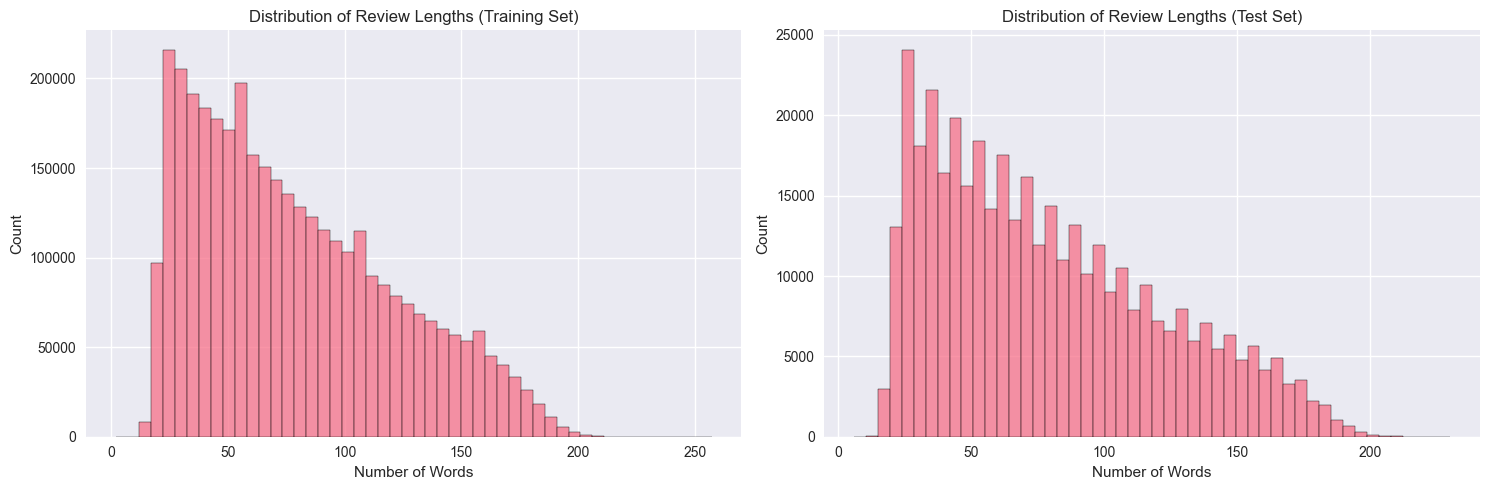

In [8]:
# Visualize review length distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=train_df, x='word_count', bins=50)
plt.title('Distribution of Review Lengths (Training Set)')
plt.xlabel('Number of Words')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.histplot(data=test_df, x='word_count', bins=50)
plt.title('Distribution of Review Lengths (Test Set)')
plt.xlabel('Number of Words')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

Most common words in training set:


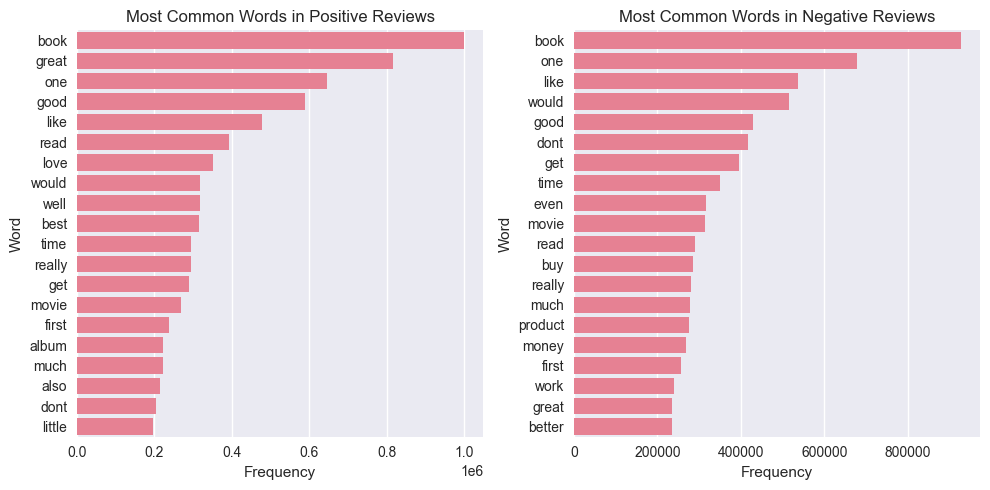

In [9]:
# Function to get most common words
def get_common_words(texts, n=20):
    # Get stopwords
    stop_words = set(stopwords.words('english'))
    
    # Combine all texts and tokenize
    words = []
    for text in texts:
        # Convert to lowercase and remove special characters
        text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
        # Tokenize
        tokens = word_tokenize(text)
        # Remove stopwords and short words
        words.extend([word for word in tokens if word not in stop_words and len(word) > 2])
    
    # Get word frequencies
    word_freq = Counter(words)
    return pd.DataFrame(word_freq.most_common(n), columns=['Word', 'Frequency'])

# Get most common words for each sentiment
def plot_common_words(df):
    plt.figure(figsize=(10, 5))
    
    # Positive reviews
    plt.subplot(1, 2, 1)
    pos_words = get_common_words(df[df['sentiment'] == 1]['review'])
    sns.barplot(data=pos_words, x='Frequency', y='Word')
    plt.title('Most Common Words in Positive Reviews')
    
    # Negative reviews
    plt.subplot(1, 2, 2)
    neg_words = get_common_words(df[df['sentiment'] == 0]['review'])
    sns.barplot(data=neg_words, x='Frequency', y='Word')
    plt.title('Most Common Words in Negative Reviews')
    
    plt.tight_layout()
    plt.show()

print("Most common words in training set:")
plot_common_words(train_df)

## Building a Simple Sentiment Analysis Model

Now let's build a basic sentiment analysis model using TF-IDF and a simple classifier.

In [10]:
# Import required libraries for modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import time

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

# Transform the data
print("Transforming text to TF-IDF features...")
start_time = time.time()
X_train = tfidf.fit_transform(train_df['review'])
X_test = tfidf.transform(test_df['review'])
print(f"Transformation completed in {time.time() - start_time:.2f} seconds")

# Train logistic regression model
print("\nTraining logistic regression model...")
model = LogisticRegression(max_iter=1000, n_jobs=-1)
start_time = time.time()
model.fit(X_train, train_df['sentiment'])
print(f"Training completed in {time.time() - start_time:.2f} seconds")

# Make predictions
y_pred = model.predict(X_test)

# Print classification report
print("\nModel Performance:")
print(classification_report(test_df['sentiment'], y_pred))

Transforming text to TF-IDF features...
Transformation completed in 733.37 seconds

Training logistic regression model...
Training completed in 297.38 seconds

Model Performance:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92    200000
           1       0.92      0.93      0.92    200000

    accuracy                           0.92    400000
   macro avg       0.92      0.92      0.92    400000
weighted avg       0.92      0.92      0.92    400000



Analyzing important features for sentiment classification:


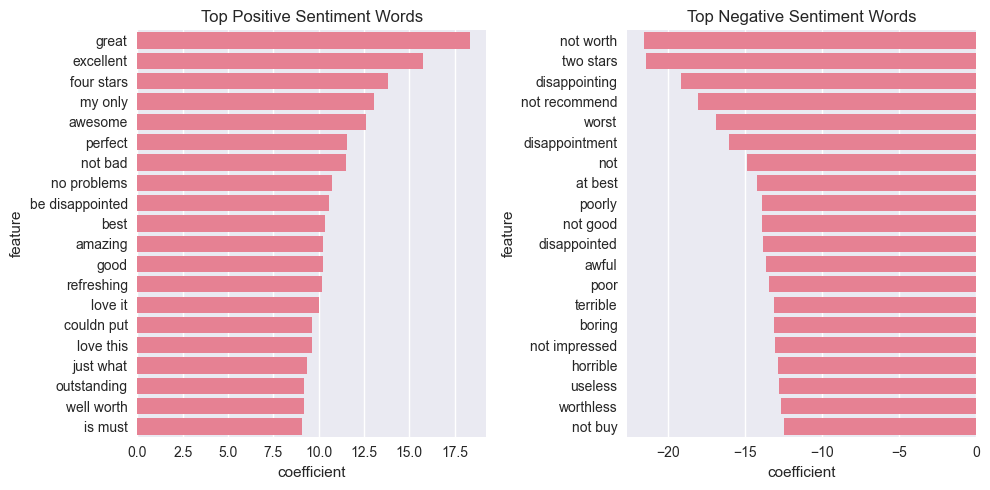

In [11]:
# Analyze most important words for each sentiment
def plot_important_features(model, vectorizer, n_top=20):
    # Get feature names and coefficients
    feature_names = vectorizer.get_feature_names_out()
    coef = model.coef_[0]
    
    # Create DataFrame of features and their coefficients
    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coef
    })
    
    # Sort by absolute value of coefficient
    coef_df['abs_coef'] = abs(coef_df['coefficient'])
    coef_df = coef_df.sort_values('abs_coef', ascending=False)
    
    # Plot top positive and negative features
    plt.figure(figsize=(10, 5))
    
    # Positive coefficients
    plt.subplot(1, 2, 1)
    pos_coef = coef_df[coef_df['coefficient'] > 0].head(n_top)
    sns.barplot(data=pos_coef, x='coefficient', y='feature')
    plt.title('Top Positive Sentiment Words')
    
    # Negative coefficients
    plt.subplot(1, 2, 2)
    neg_coef = coef_df[coef_df['coefficient'] < 0].head(n_top)
    sns.barplot(data=neg_coef, x='coefficient', y='feature')
    plt.title('Top Negative Sentiment Words')
    
    plt.tight_layout()
    plt.show()

print("Analyzing important features for sentiment classification:")
plot_important_features(model, tfidf)

## Conclusion

We've performed a comprehensive analysis of the Amazon reviews dataset and built a simple sentiment analysis model. The analysis includes:

1. Basic statistics about the reviews
2. Distribution of review lengths
3. Most common words in positive and negative reviews
4. A TF-IDF based sentiment classification model
5. Analysis of the most important features for sentiment classification

The model can be improved further by:
1. Using more sophisticated text preprocessing
2. Trying different models (e.g., BERT, RoBERTa)
3. Performing hyperparameter tuning
4. Using cross-validation for more robust evaluation